# Polyfill boundaries and padding
Livable streets App

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#creating geometry (city boundaries)
from shapely.ops import linemerge, unary_union, polygonize

#geojson
import os 
import geojson
import json

#plotting in folium
import geopandas as gpd

#working with h3
import h3
import pandas as pd

# #turning off shapely warnings
# import warnings
from shapely.geometry import Polygon
# from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings('ignore', category=ShapelyDeprecationWarning)

#plotting with keplerGL
import keplergl as kp

#workingdir
get_working_dir = os.getcwd()

#saving
import fiona




### open geojson

In [3]:
city_name = "Kreuzberg"

city_boundary_gpd = gpd.read_file(f'{get_working_dir}/data/{city_name}_boundary.gpkg')
city_boundary_gpd

,name,geometry
0,Kreuzberg,"POLYGON ((13.36858 52.49396, 13.36841 52.49448..."
1,Kreuzberg_buffer,"POLYGON ((13.36442 52.49473, 13.36447 52.49528..."


In [4]:
city_boundary = gpd.read_file(f'{get_working_dir}/data/{city_name}_boundary.gpkg')
city_boundary.geometry[0].__geo_interface__

{'type': 'Polygon',
 'coordinates': (((13.3685807, 52.4939555),
   (13.3684148, 52.4944781),
   (13.3684522, 52.4949243),
   (13.3684812, 52.4952231),
   (13.3685297, 52.4957465),
   (13.368538, 52.4958578),
   (13.3685916, 52.4964588),
   (13.3685962, 52.4965108),
   (13.3686239, 52.4967435),
   (13.3686269, 52.4967761),
   (13.3686362, 52.496877),
   (13.3686779, 52.4973847),
   (13.369601, 52.4981061),
   (13.3697289, 52.4987765),
   (13.3695143, 52.498879),
   (13.370362, 52.4995305),
   (13.3705522, 52.4996846),
   (13.3705545, 52.4996818),
   (13.370587, 52.4996836),
   (13.3708251, 52.4998602),
   (13.3708884, 52.4999544),
   (13.3713442, 52.501634),
   (13.3714531, 52.501758),
   (13.3717361, 52.5020391),
   (13.3721632, 52.5024872),
   (13.373043, 52.5033823),
   (13.3736093, 52.504164),
   (13.3742442, 52.5034855),
   (13.3746784, 52.5032356),
   (13.3747522, 52.5032345),
   (13.3749797, 52.5033759),
   (13.377639, 52.5079091),
   (13.3776503, 52.5079658),
   (13.3789222, 52.

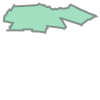

In [5]:
city_boundary_gpd['geometry'][0]

# Hexagons H3

In [6]:
res = 10

## geometry to H3 indexes (polyfill)

In [7]:
# parks_gdf_h3 = parks_gdf_read.copy()
# parks_gdf_h3['h3_index'] = parks_gdf_h3['geometry'].apply(
#     lambda polys: h3.polyfill(mapping(polys), res, geo_json_conformant=True)
#     if bool(h3.polyfill(mapping(polys), res)) 
#     else {h3.geo_to_h3(polys.centroid.y, polys.centroid.x, res)})
# parks_gdf_h3.set_index('id', inplace=True)
# parks_gdf_h3

hex_inner_polyfill = list(h3.polyfill(city_boundary_gpd.geometry[0].__geo_interface__, res, geo_json_conformant=True))
hex_outer_polyfill = list(h3.polyfill(city_boundary_gpd.geometry[1].__geo_interface__, res, geo_json_conformant=True))

hex_id_inner = pd.Series(hex_inner_polyfill)
hex_id_outer = pd.Series(hex_outer_polyfill)

hex_inner_df = pd.DataFrame({'hex_id' : hex_id_inner})
hex_outer_df = pd.DataFrame({'hex_id' : hex_id_outer})

In [8]:
hex_outer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hex_id  1332 non-null   object
dtypes: object(1)
memory usage: 10.5+ KB


In [9]:
hex_id_merge = pd.merge(hex_inner_df, hex_outer_df, how='outer', indicator=True) 
hex_id_merge['_merge'] = hex_id_merge['_merge'].map({'both':1, 'right_only':0})
hex_id_merge


,hex_id,_merge
0,8a1f18b25867fff,1.0
1,8a1f18b25477fff,1.0
2,8a1f18b2499ffff,1.0
3,8a1f18b24967fff,1.0
4,8a1f1d4d679ffff,1.0
...,...,...
1327,8a1f18b2096ffff,0.0
1328,8a1f1d4d602ffff,0.0
1329,8a1f1d4d2147fff,0.0
1330,8a1f1d48bc47fff,0.0


## hex_ids to Hexagon(Polygons)

In [10]:
# parks_gdf_h3['h3_poly'] = parks_gdf_h3['h3_index'].apply(lambda h3_polygon: 
#     geometry.MultiPolygon(
#     geometry.Polygon(h3.h3_to_geo_boundary(h3_cell, geo_json=True))
#     for h3_cell in h3_polygon
#     )
# )


hex_id_merge.dropna(inplace=True)

hex_id_merge['geometry'] = hex_id_merge['hex_id'].apply(lambda h3_polygon: 
    Polygon(h3.h3_to_geo_boundary(h3_polygon, geo_json=True))
)
hex_id_merge

,hex_id,_merge,geometry
0,8a1f18b25867fff,1.0,POLYGON ((13.412445661918353 52.50036508584357...
1,8a1f18b25477fff,1.0,POLYGON ((13.404410050313382 52.48684245417146...
2,8a1f18b2499ffff,1.0,POLYGON ((13.367851044456605 52.49552943433168...
3,8a1f18b24967fff,1.0,"POLYGON ((13.374358571279773 52.5005065862445,..."
4,8a1f1d4d679ffff,1.0,POLYGON ((13.425775737921187 52.50152772367281...
...,...,...,...
1327,8a1f18b2096ffff,0.0,POLYGON ((13.395187639134678 52.48416644896572...
1328,8a1f1d4d602ffff,0.0,"POLYGON ((13.428694347127355 52.5108618797438,..."
1329,8a1f1d4d2147fff,0.0,"POLYGON ((13.44863631427175 52.49657385745055,..."
1330,8a1f1d48bc47fff,0.0,"POLYGON ((13.3841548915115 52.509910036445866,..."


In [11]:
#convert geometry to geodataframe
hex_id_merge = gpd.GeoDataFrame(hex_id_merge, geometry='geometry', crs="EPSG:4326")
hex_id_merge

,hex_id,_merge,geometry
0,8a1f18b25867fff,1.0,"POLYGON ((13.41245 52.50037, 13.41213 52.49976..."
1,8a1f18b25477fff,1.0,"POLYGON ((13.40441 52.48684, 13.40409 52.48624..."
2,8a1f18b2499ffff,1.0,"POLYGON ((13.36785 52.49553, 13.36754 52.49492..."
3,8a1f18b24967fff,1.0,"POLYGON ((13.37436 52.50051, 13.37404 52.49990..."
4,8a1f1d4d679ffff,1.0,"POLYGON ((13.42578 52.50153, 13.42546 52.50092..."
...,...,...,...
1327,8a1f18b2096ffff,0.0,"POLYGON ((13.39519 52.48417, 13.39487 52.48356..."
1328,8a1f1d4d602ffff,0.0,"POLYGON ((13.42869 52.51086, 13.42838 52.51026..."
1329,8a1f1d4d2147fff,0.0,"POLYGON ((13.44864 52.49657, 13.44832 52.49597..."
1330,8a1f1d48bc47fff,0.0,"POLYGON ((13.38415 52.50991, 13.38384 52.50930..."


# KeplerGL

## Keplergl map with polygon geometry

In [12]:
city_name = 'Kreuzberg'
file_name= os.path.join(get_working_dir, 'data', f'{city_name}_keplerconfig.json')
f = open(file_name)
config = json.load(f)

In [13]:
map_1 = kp.KeplerGl(config=config)
map_1.add_data(data = hex_id_merge[['_merge','geometry']], name='h3')
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'y0azgql', 'type': …

In [14]:
map_1.config

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'y0azgql',
     'type': 'geojson',
     'config': {'dataId': 'h3',
      'label': 'h3',
      'color': [23, 184, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.17,
       'strokeOpacity': 0.8,
       'thickness': 0.1,
       'strokeColor': [246, 209, 138],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50

In [15]:
with open(os.path.join(get_working_dir, 'data', f"{city_name}_keplerconfig.json"), "w") as f:
    f.write(json.dumps(map_1.config, indent=4))

## saving h3 cells

https://feed.terramonitor.com/shapefile-vs-geopackage-vs-geojson/

In [16]:
# hex_id_merge.to_file(f'{working_dir}/data/{city_name}_hexagons.shp')  
# hex_id_merge.to_file(f'{working_dir}/data/{city_name}_hexagons.geojson', driver='GeoJSON')  

hex_id_merge.to_file(f'{get_working_dir}/data/{city_name}_hexagons.gpkg', driver='GPKG', layer='name')  


https://github.com/kevinschaich/h3-pyspark

in case the base module h3 fails with geometry